# Reproduce the pancreatic endocrinogenesis case study of VeloVAE

In this notebook, we follow the instructions of VeloVAE and are able to reproduce the case study of pancreatic endocrinogenesis by [Gu et al.](https://www.biorxiv.org/content/10.1101/2022.07.08.499381v2.full) in bioRxiv (doi: https://doi.org/10.1101/2022.07.08.499381; version 2).

## Build environment and install dependencies

We create the environment of VeloVAE by running the commands below in an anaconda environment. We download the latest VeloVAE from https://github.com/welch-lab/VeloVAE on the main thread (commit: 018ee60998c9b63f441fdfc4836dbd5baadf1459).

`conda create -n velovae python=3.7.6`

`conda activate velovae`

`pip install scvelo`

`pip install loess`

`pip install louvain`

# Import packages

In [1]:
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path
sys.path.append('..')
import velovae as vv

# Load pancreatic endocrinogenesis data
We follow the full pipeline of VeloVAE to train the pancreatic endocrinogenesis data.

In [2]:
dataset = "Pancreas"
adata = scv.datasets.pancreas()
adata

  0%|          | 0.00/50.0M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [3]:
# Set the parent folder names for saving model parameters, data and figures.
model_path_base = f"checkpoints/{dataset}"
figure_path_base = f"figures/{dataset}"
data_path_base = f"data/{dataset}"
# Define the genes to be plot
gene_plot = ["Nnat", "Smoc1"]

# Preprocessing
We apply exactly the same preprocessing steps as VeloVAE.

In [4]:
Ngene = 2000
vv.preprocess(adata, Ngene)

Filtered out 21061 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Pick some genes to plot.

# Run VeloVAE

We run DeepVelo with the same configurations in the instruction.

In [5]:
# VeloVAE model
## Define saving paths
figure_path = figure_path_base+"/VAE"
model_path = model_path_base+"/VAE"
data_path = data_path_base

In [6]:
torch.manual_seed(2022)
np.random.seed(2022)
## Create a VeloVAE object
vae = vv.VAE(adata, tmax=20, dim_z=5, device='cpu')

Initialization using the steady-state and dynamical models.
Gaussian Prior.


In [7]:
## Mini-batch training
vae.train(adata, gene_plot=gene_plot, plot=True, figure_path=figure_path, embed="umap")

--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
Epoch 1: Train ELBO = -12961.801, Test ELBO = -231129.766, 	 Total Time =   0 h :  0 m :  3 s
Epoch 100: Train ELBO = 794.399, Test ELBO = 803.284, 	 Total Time =   0 h :  3 m :  7 s
Epoch 200: Train ELBO = 1624.300, Test ELBO = 1635.045, 	 Total Time =   0 h :  6 m :  9 s
Epoch 300: Train ELBO = 1952.917, Test ELBO = 1954.591, 	 Total Time =   0 h :  8 m : 56 s
Epoch 400: Train ELBO = 2079.960, Test ELBO = 2063.556, 	 Total Time =

In [8]:
## Save results
vae.save_model(model_path, 'encoder_vae', 'decoder_vae')
vae.save_anndata(adata, 'vae', data_path, file_name="pancreas_out.h5ad")

In [9]:
# Full VB model
## Define saving paths
figure_path = figure_path_base+"/FullVB"
model_path = model_path_base+"/FullVB"
data_path = data_path_base

In [10]:
torch.manual_seed(2022)
np.random.seed(2022)
## Create a full VB object
full_vb = vv.VAEFullVB(adata, tmax=20, dim_z=5, device='cuda:0')

Initialization using the steady-state and dynamical models.
Gaussian Prior.


In [11]:
## Mini-batch training
full_vb.train(adata, plot=True, gene_plot=gene_plot, figure_path=figure_path, embed="umap")

--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
Epoch 1: Train ELBO = -12638.800, Test ELBO = -230957.172, 	 Total Time =   0 h :  0 m :  4 s
Epoch 100: Train ELBO = 836.583, Test ELBO = 747.206, 	 Total Time =   0 h :  2 m : 47 s
Epoch 200: Train ELBO = 1606.315, Test ELBO = 1577.980, 	 Total Time =   0 h :  5 m : 32 s
Epoch 300: Train ELBO = 1930.151, Test ELBO = 1891.874, 	 Total Time =   0 h :  8 m : 17 s
Epoch 400: Train ELBO = 2048.866, Test ELBO = 2009.149, 	 Total Time =

In [12]:
## Save results
full_vb.save_model(model_path, "encoder_fullvb","decoder_fullvb")
full_vb.save_anndata(adata, 'fullvb', data_path, file_name="pancreas_out.h5ad")

In [13]:
# Branching ODE model
## Define saving paths
figure_path = figure_path_base+"/BrODE"
model_path = model_path_base+"/BrODE"
data_path = data_path_base

In [14]:
torch.manual_seed(2022)
np.random.seed(2022)
## Create a Branching ODE object
brode = vv.BrODE(adata, "clusters", "fullvb_time", "fullvb_z", graph_param={"dt":(0.01,0.05), "k":5, "n_par":2})

Graph Partition
Number of partitions:  1
Computing type-to-type transition probability
Obtaining the MST in each partition
Initialization using type-specific dynamical model.


In [15]:
## Mini-batch Training
brode.train(adata, "fullvb_time", "clusters", plot=True, gene_plot=gene_plot, figure_path=figure_path)

------------------------ Train a Branching ODE ------------------------
               Alpha  Beta  Delta  Ductal  Epsilon  Ngn3 high EP  Ngn3 low EP  Pre-endocrine
Alpha            0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Beta             0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Delta            0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Ductal           0.0   0.0    0.0     1.0      0.0           0.0          0.0            0.0
Epsilon          0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Ngn3 high EP     0.0   0.0    0.0     0.0      0.0           0.0          1.0            0.0
Ngn3 low EP      0.0   0.0    0.0     1.0      0.0           0.0          0.0            0.0
Pre-endocrine    0.0   0.0    0.0     0.0      0.0           1.0          0.0            0.0
*********        Creating Training/Validation Datasets        *********
*********          

In [16]:
## Save results
brode.save_model(model_path, "brode")
brode.save_anndata(adata, 'brode', data_path, file_name="pancreas_out.h5ad")

In [17]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'n_counts', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'vanilla_time', 'vanilla_std_t', 'vae_time', 'vae_std_t', 'vae_t0', 'fullvb_time', 'fullvb_std_t', 'fullvb_t0', 'partition', 'brode_time', 'brode_label'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'vanilla_alpha', 'vanilla_beta', 'vanilla_gamma', 'vanilla_toff', 'vanilla_ton', 'vanilla_scaling', 'vanilla_sigma_u', 'vanilla_sigma_s', 'vae_alpha', 'vae_beta', 'vae_gamma', 'vae_ton', 'vae_scaling', 'vae_sigma_u', 'vae_sigma_s', 'vae_likelihood', 'fullvb_logmu_alpha', 'fullvb_logmu_beta', 'fullvb_logmu_gamma', 'fullvb_logstd_alpha', 'fullvb_logstd_beta', 'fullvb_logstd_gamma', 'fullvb_ton', 'fullvb_scaling', 'fullvb_sigma_u', 'fullvb_sigma_s', 'fullvb_likelihood', 'brode_scaling', 'brode_sigma_u', 'brode_sigma_s'
    uns

# Display cell state uncertainty and cell time uncertainty

We follow the instructions of VeloVAE to display cell state uncertainty and cell time uncertainty.

In [18]:
key = "fullvb"
basis = "umap"

## Cell state uncertainty (Fig. S5a in [Gu et al.](https://www.biorxiv.org/content/10.1101/2022.07.08.499381v1?versioned=true))

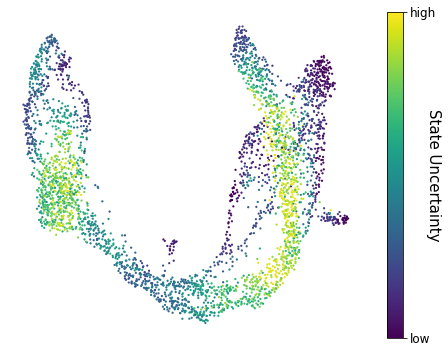

In [19]:
std_z = adata.obsm[f"{key}_std_z"]
z = adata.obsm[f"{key}_z"]
X_embed = adata.obsm[f"X_{basis}"]
#vv.plotting.plot_state_var(std_z, X_embed, z, save=f"figures/Pancreas/pancreas_state_var.png")
vv.plotting.plot_state_var(std_z, X_embed, z)

##  Cell time uncertainty (Fig. S6a in [Gu et al.](https://www.biorxiv.org/content/10.1101/2022.07.08.499381v1?versioned=true))

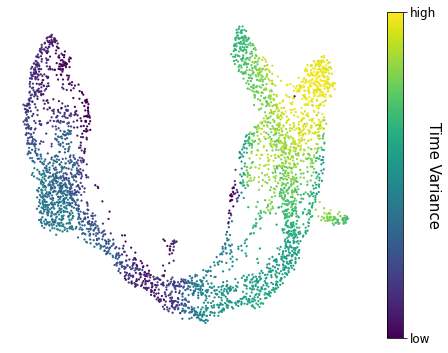

In [20]:
t = adata.obs["fullvb_time"].to_numpy()
std_t = adata.obs["fullvb_std_t"].to_numpy()
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_time_var(std_t, X_embed, t, save=None)

# Plot velocity in embedding space (Fig. 2c in [Gu et al.](https://www.biorxiv.org/content/10.1101/2022.07.08.499381v1?versioned=true))

We follow the instructions of VeloVAE to display the velocity in embedding space.

computing velocity graph (using 1/16 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:31) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Pancreas/Pancreas_velocity_vae.png


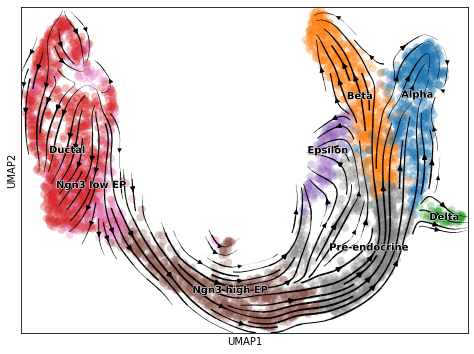

In [21]:
key = 'vae'
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity')
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', title="", figsize=(8,6), frameon=True, \
    save=f'{figure_path_base}/{dataset}_velocity_{key}.png', palette=colors, color='clusters')

In [22]:
adata.write_h5ad(data_path_base+"/pancreas_out.h5ad")

# Plots of individual genes fit by VeloVAE (right panel of Fig. 2c in [Gu et al.](https://www.biorxiv.org/content/10.1101/2022.07.08.499381v1?versioned=true))

We follow the instructions of VeloVAE to display the plots of sample genes.

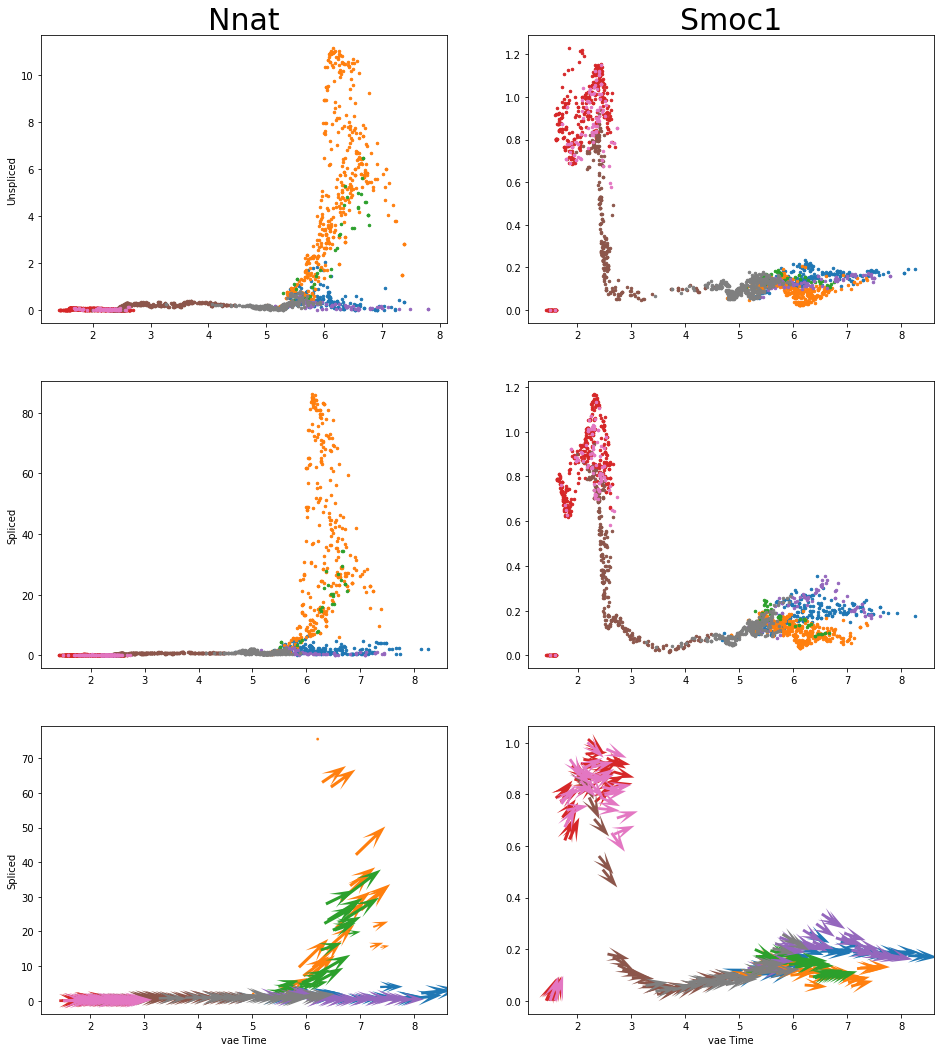

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,18), nrows=3, ncols=2)
for i in range(len(gene_plot)):
    gene = adata.var.index == gene_plot[i]
    method='vae'
    t=adata.obs[f'{method}_time']
    u=adata.layers[f'{method}_u0'][:, gene]
    s=adata.layers[f'{method}_s0'][:, gene]
    v=adata.layers[f'{method}_velocity'][:,gene]
    u_pred = adata.layers[f'{method}_uhat'][:, gene]
    s_pred = adata.layers[f'{method}_shat'][:, gene]

    cell_labels = adata.obs['clusters']
    legends = np.unique(cell_labels)
    labels = cell_labels.replace(legends, value=range(len(legends)))

    vv.plotting.plot_sig_axis(ax[0,i], t, u, labels=labels, title= gene_plot[i], legends=legends)
    vv.plotting.plot_sig_axis(ax[1,i], t, s, labels=labels, legends=legends)
    vv.plotting.plot_vel_axis(ax=ax[2,i], t=t, x=s, v=v, labels=labels, legends=np.unique(cell_labels))

    ax[2,i].set_xlabel(f'{method} Time')
    ax[0,0].set_ylabel('Unspliced')
    ax[1,0].set_ylabel('Spliced')
    ax[2,0].set_ylabel('Spliced')

plt.show()

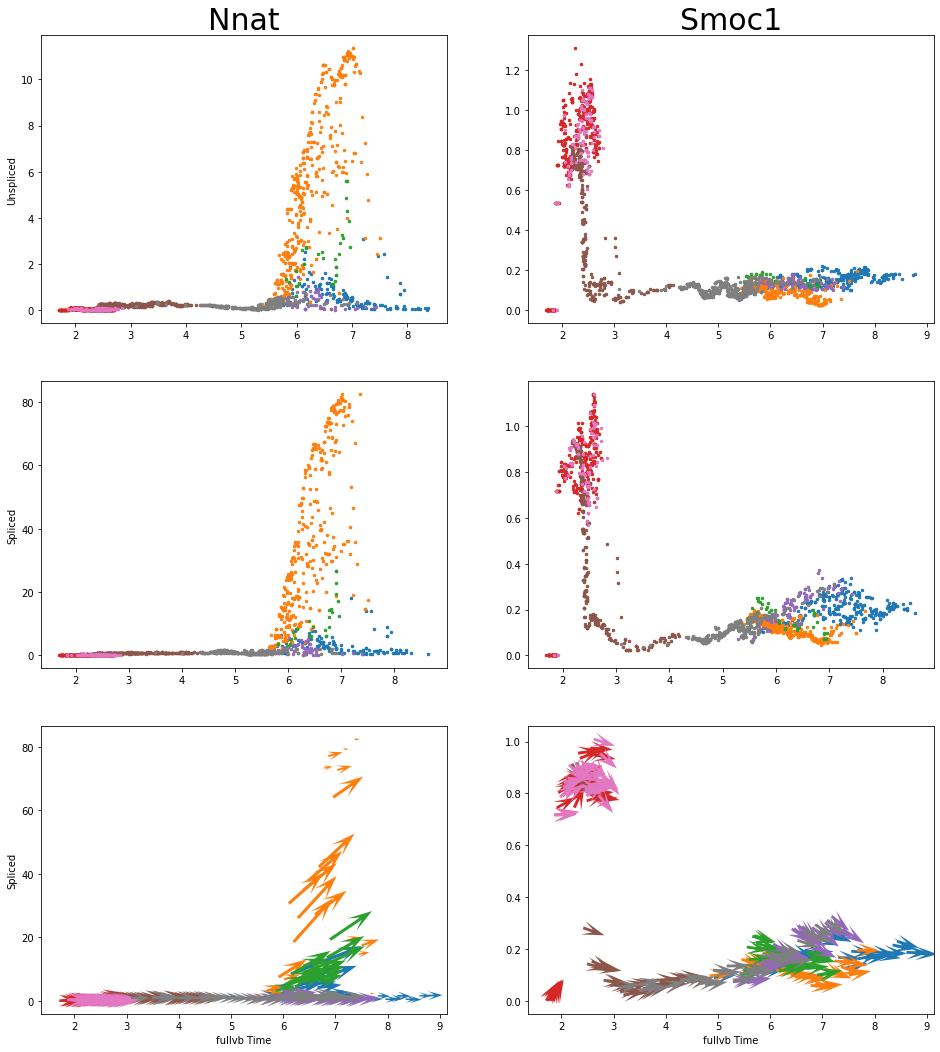

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,18), nrows=3, ncols=2)
for i in range(len(gene_plot)):
    gene = adata.var.index == gene_plot[i]
    method='fullvb'
    t=adata.obs[f'{method}_time']
    u=adata.layers[f'{method}_u0'][:, gene]
    s=adata.layers[f'{method}_s0'][:, gene]
    v=adata.layers[f'{method}_velocity'][:,gene]
    u_pred = adata.layers[f'{method}_uhat'][:, gene]
    s_pred = adata.layers[f'{method}_shat'][:, gene]

    cell_labels = adata.obs['clusters']
    legends = np.unique(cell_labels)
    labels = cell_labels.replace(legends, value=range(len(legends)))

    vv.plotting.plot_sig_axis(ax[0,i], t, u, labels=labels, title= gene_plot[i], legends=legends)
    vv.plotting.plot_sig_axis(ax[1,i], t, s, labels=labels, legends=legends)
    vv.plotting.plot_vel_axis(ax=ax[2,i], t=t, x=s, v=v, labels=labels, legends=np.unique(cell_labels))

    ax[2,i].set_xlabel(f'{method} Time')
    ax[0,0].set_ylabel('Unspliced')
    ax[1,0].set_ylabel('Spliced')
    ax[2,0].set_ylabel('Spliced')

plt.show()

# Branching genes BrODE plots (Fig. 3 in [Gu et al.](https://www.biorxiv.org/content/10.1101/2022.07.08.499381v1?versioned=true))

We follow the instructions of VeloVAE to display the BrODE plots for branching genes.

In [25]:
branching_gene = ['Ppp1r1a', 'Rnf130', '1500009L16Rik']

## Examples of individual genes fit by the branching ODE model (Fig. 3e in [Gu et al.](https://www.biorxiv.org/content/10.1101/2022.07.08.499381v1?versioned=true))

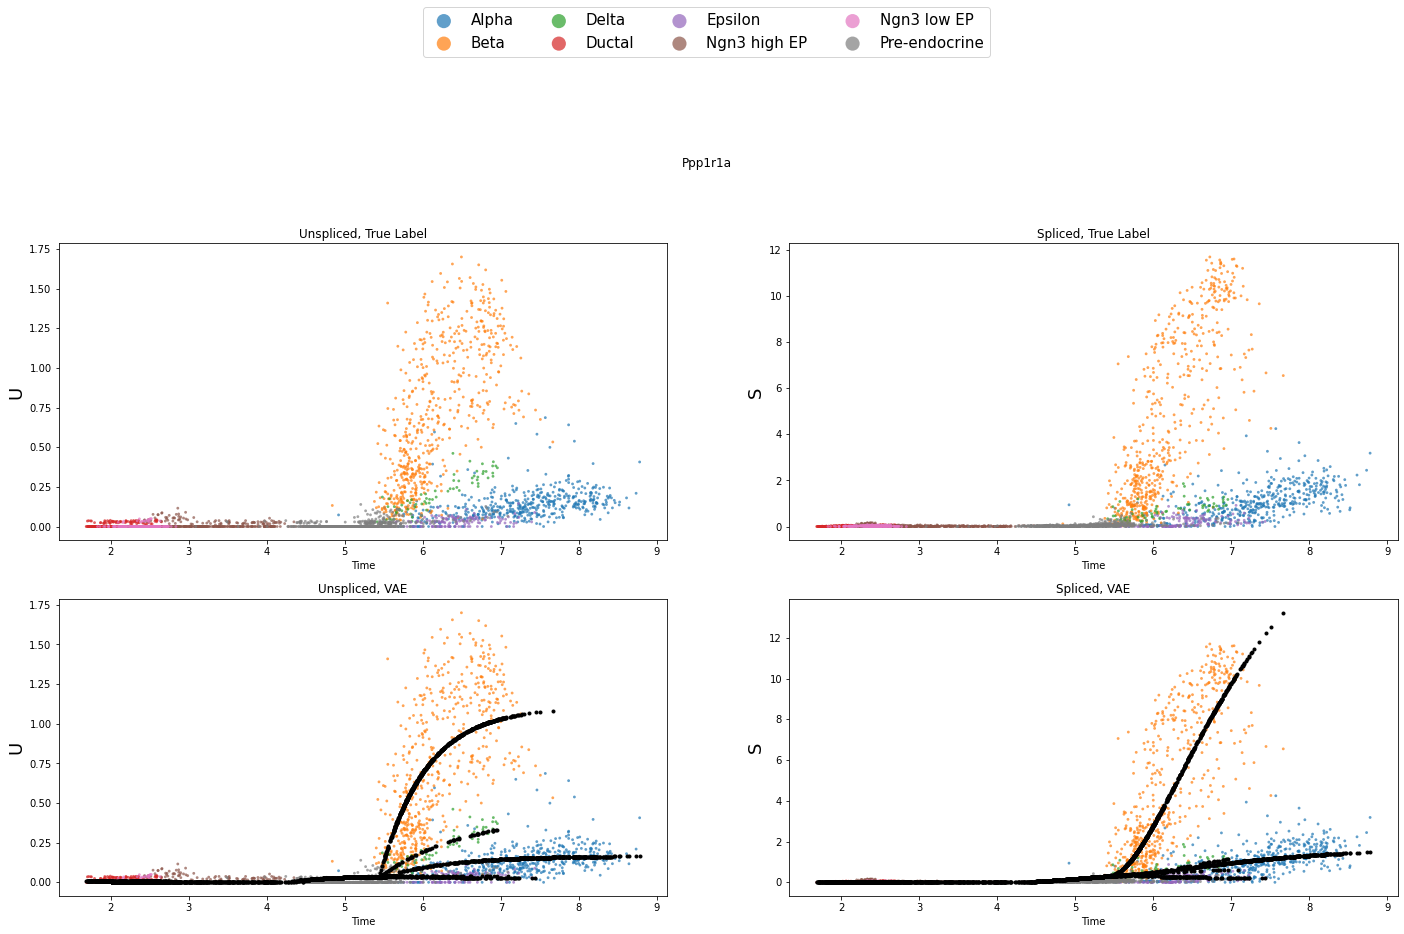

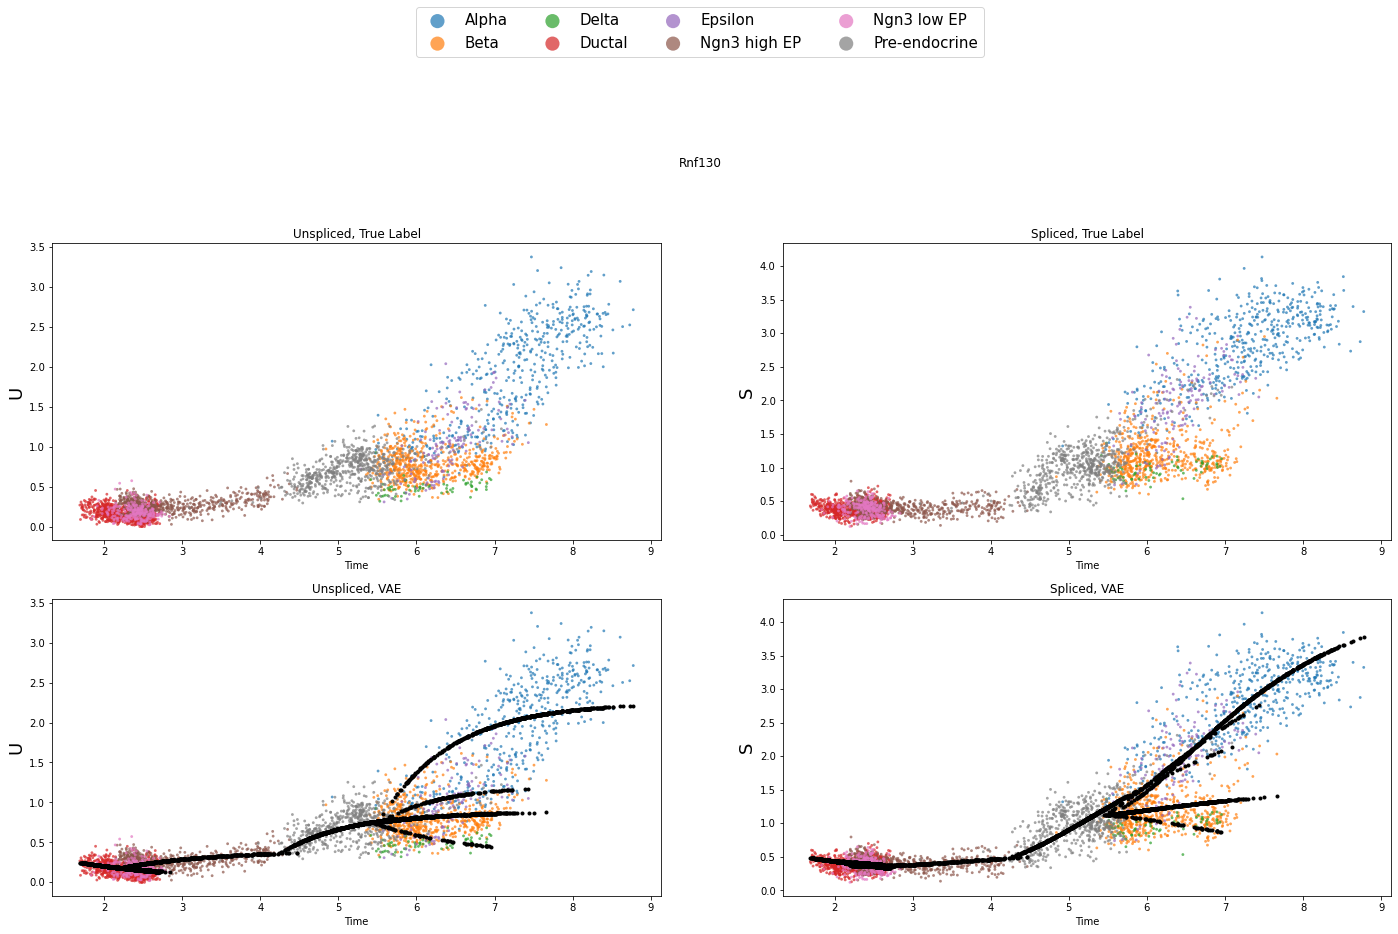

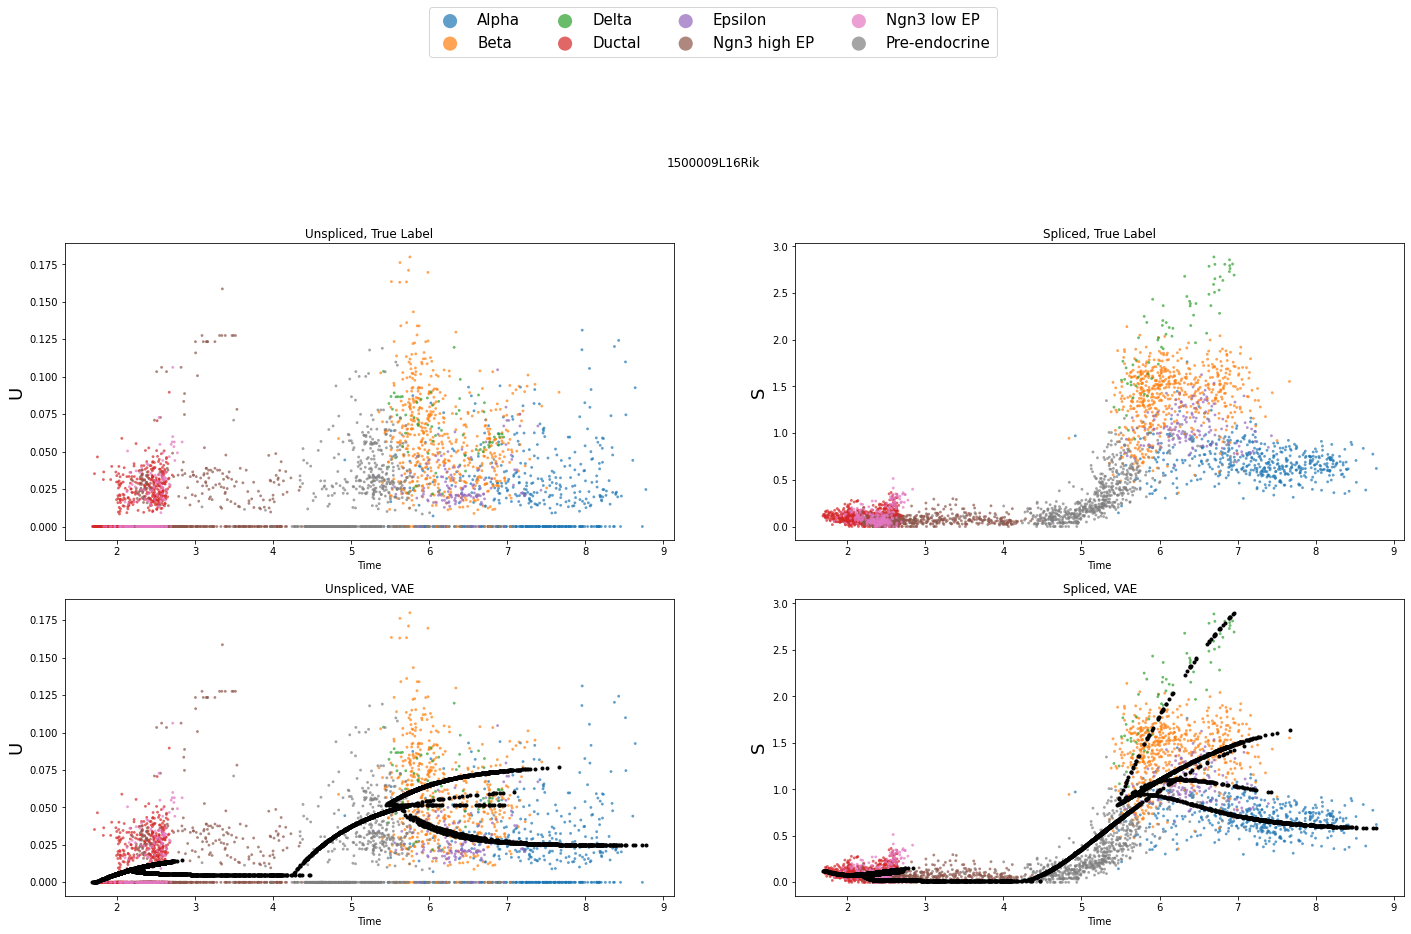

In [26]:
for i in range(len(branching_gene)):
    gene = adata.var.index == branching_gene[i]
    method='brode'
    t=adata.obs[f'{method}_time']
    u=adata.layers['Mu'][:, gene]
    s=adata.layers['Ms'][:, gene]

    v=adata.layers[f'{method}_velocity'][:,gene]
    u_pred = adata.layers[f'{method}_uhat'][:, gene]
    s_pred = adata.layers[f'{method}_shat'][:, gene]

    cell_labels = adata.obs['clusters']

    vv.plotting.plot_sig(t.to_numpy(), u, s, u_pred, s_pred, cell_labels=cell_labels.to_numpy(), title=branching_gene[i])

plt.show()

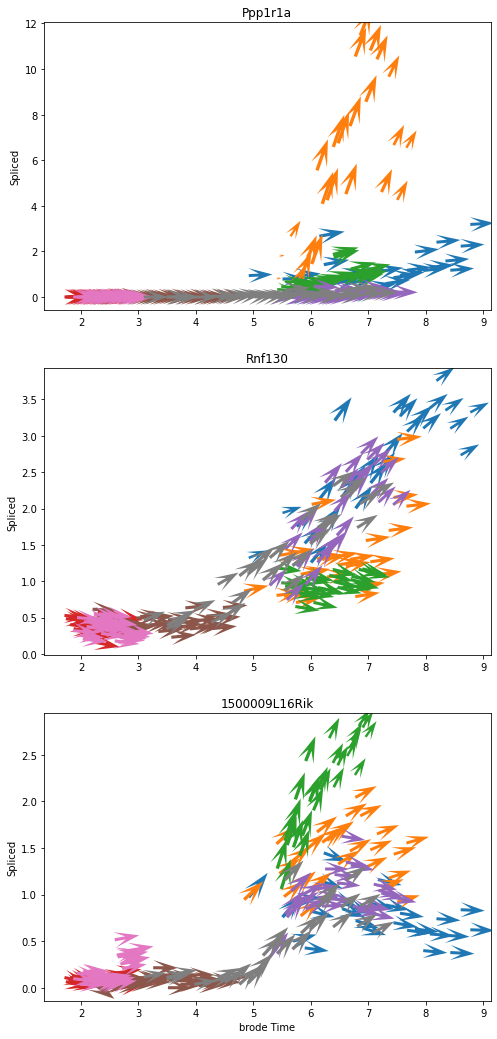

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,18), nrows=3, ncols=1)
for i in range(len(branching_gene)):
    gene = adata.var.index == branching_gene[i]
    method='brode'
    t=adata.obs[f'{method}_time']
    u=adata.layers['Mu'][:, gene]
    s=adata.layers['Ms'][:, gene]
    v=adata.layers[f'{method}_velocity'][:,gene]
    
    cell_labels = adata.obs['clusters']
    legends = np.unique(cell_labels)
    labels = cell_labels.replace(legends, value=range(len(legends)))

    vv.plotting.plot_vel_axis(ax=ax[i], t=t, x=s, v=v, labels=labels, legends=np.unique(cell_labels))

    ax[2].set_xlabel(f'{method} Time')
    ax[i].set_ylabel('Spliced')
    ax[i].set_title(branching_gene[i])

plt.show()